In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import copy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score

# Reading data and basic info

In [2]:
df = pd.read_csv('movie_review_data.csv')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

`gross` and `budget` have more ~10% missing values. Will impute these in data preparation before model training step.

In [3]:
print('Numerical feature count - {}'.format(df.select_dtypes(exclude=['object']).drop('imdb_score', axis=1).shape[1]))
print('Categorical feature count - {}'.format(df.select_dtypes(include=['object']).shape[1]))

Numerical feature count - 15
Categorical feature count - 12


count    5043.000000
mean        6.442138
std         1.125116
min         1.600000
25%         5.800000
50%         6.600000
75%         7.200000
max         9.500000
Name: imdb_score, dtype: float64


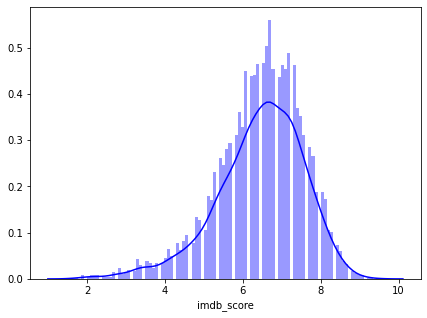

In [4]:
print(df['imdb_score'].describe())
plt.figure(figsize=(7, 5))
sns.distplot(df['imdb_score'], color='b', bins=100, hist_kws={'alpha': 0.4})

The target variable `imdb_score` looks normally distributed. Most movies are rated between 6 to 7.5, which shows general trend of movie ratings.

# Numerical Feature Distribution

In [5]:
df_num = df.select_dtypes(exclude=['object'])
df_num.head()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,723.0,178.0,0.0,855.0,1000.0,760505847.0,886204,4834,0.0,3054.0,237000000.0,2009.0,936.0,7.9,1.78,33000
1,302.0,169.0,563.0,1000.0,40000.0,309404152.0,471220,48350,0.0,1238.0,300000000.0,2007.0,5000.0,7.1,2.35,0
2,602.0,148.0,0.0,161.0,11000.0,200074175.0,275868,11700,1.0,994.0,245000000.0,2015.0,393.0,6.8,2.35,85000
3,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,1144337,106759,0.0,2701.0,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,NaN,131.0,NaN,131.0,NaN,8,143,0.0,NaN,NaN,NaN,12.0,7.1,NaN,0


/home/ubuntu/miniconda3/envs/test_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/ubuntu/miniconda3/envs/test_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/ubuntu/miniconda3/envs/test_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNu

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe3a05aea10>,
      dtype=object)

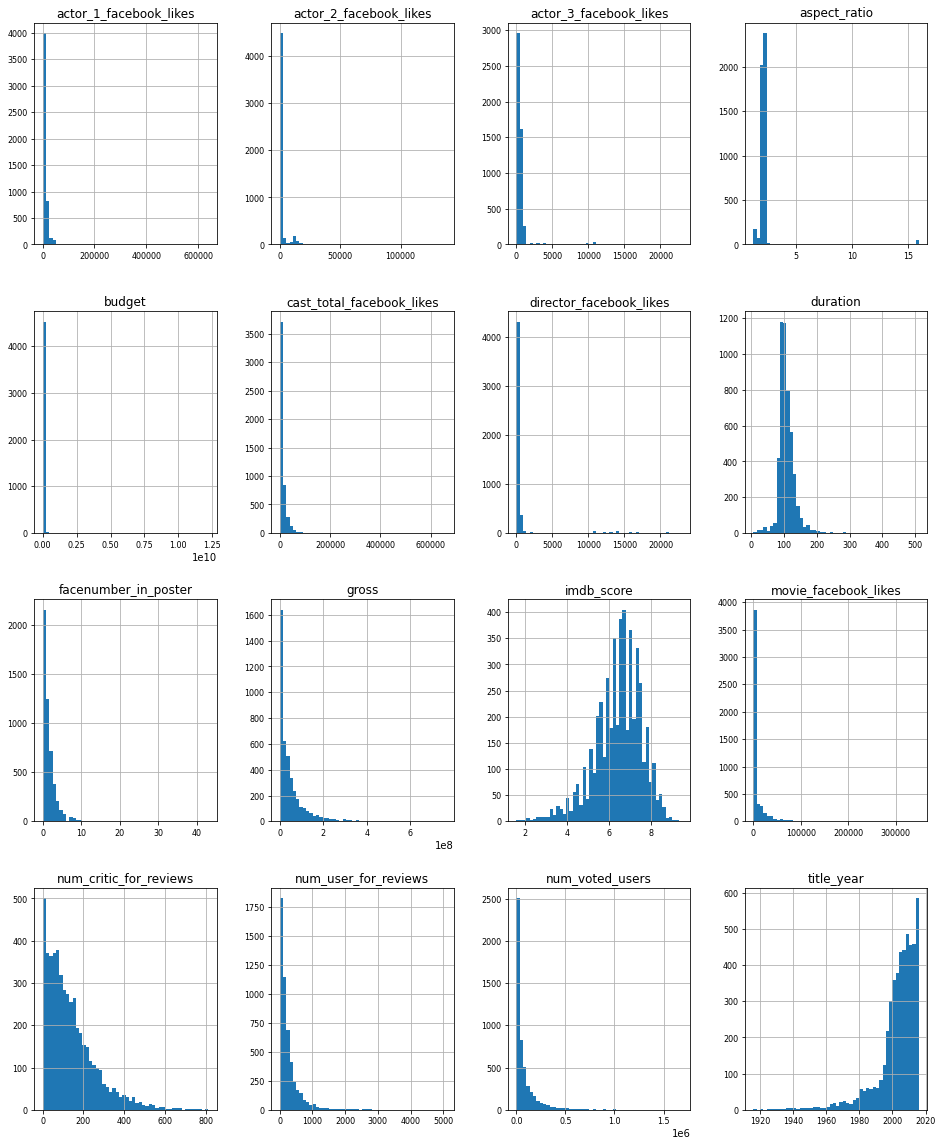

In [6]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

Features concerned with facebook likes seems to have some outliers. We can treat these by replacing with the edge values of the column.

## Correlation with `imdb_score`

In [7]:
df_num_corr = df_num.corr()['imdb_score']
high_corr_num_feat = df_num_corr[abs(df_num_corr) > 0.4].sort_values(ascending=False)
print("There is {} strongly correlated values with imdb_score:\n{}".format(len(high_corr_num_feat), high_corr_num_feat))

There is 2 strongly correlated values with imdb_score:
imdb_score         1.000000
num_voted_users    0.410965
Name: imdb_score, dtype: float64


Only `num_voted_users` seems to have little bit of correlation with `imdb_score`.

Correlation by itself does not always explain the relationship between data so ploting them could even lead us to new insights.

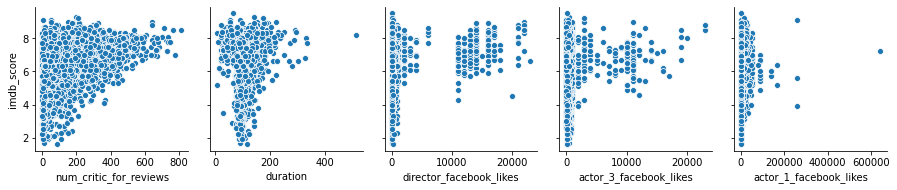

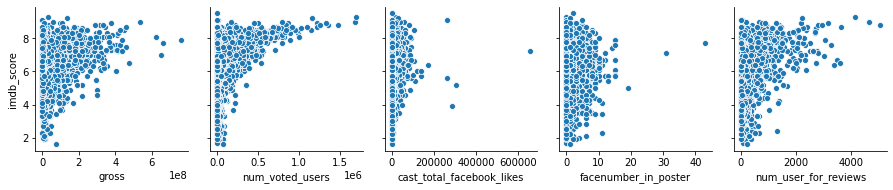

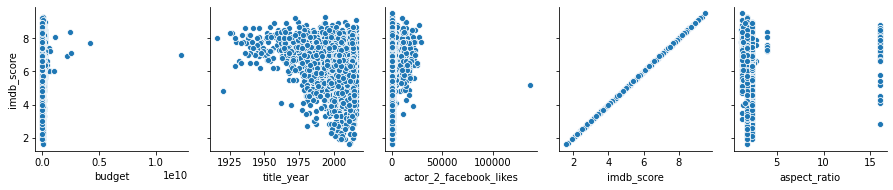

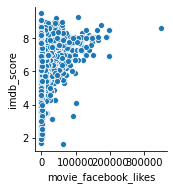

In [8]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['imdb_score'])

None of the features show any linear or curvilinear relationship with `imdb_score`. Also, if we look closely at the data, we can see that a lot of data points are located on `x = 0` which may indicate the absence of such feature in the movie.

So now lets remove these 0 values and try checking the correlation again.

In [9]:
individual_features_df = []
for i in range(0, len(df_num.columns) - 1):
    tmpDf = df_num[[df_num.columns[i], 'imdb_score']]
    tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['imdb_score'].iloc[0]
                    for feature in individual_features_df
                    if feature.columns[0] != 'imdb_score'}

all_correlations = sorted(all_correlations.items(), key=lambda x: x[1], reverse=True)

for (key, value) in all_correlations:
    print("{}: {}".format(key, value))

num_voted_users: 0.41096520027034994
num_critic_for_reviews: 0.3053028591822166
num_user_for_reviews: 0.29247543745185667
duration: 0.26166152097667805
director_facebook_likes: 0.20637840181662587
gross: 0.19802122755403362
cast_total_facebook_likes: 0.08836446236141468
actor_2_facebook_likes: 0.08669814822536188
actor_1_facebook_likes: 0.07793715685353679
aspect_ratio: 0.059445227874183416
actor_3_facebook_likes: 0.05638537391160606
budget: 0.030687727112958172
facenumber_in_poster: -0.05480409937805725
title_year: -0.2091670045647585


This doesn't improve the correlation between target variable `imdb_score` and independent features.

## Numerical feature correlations

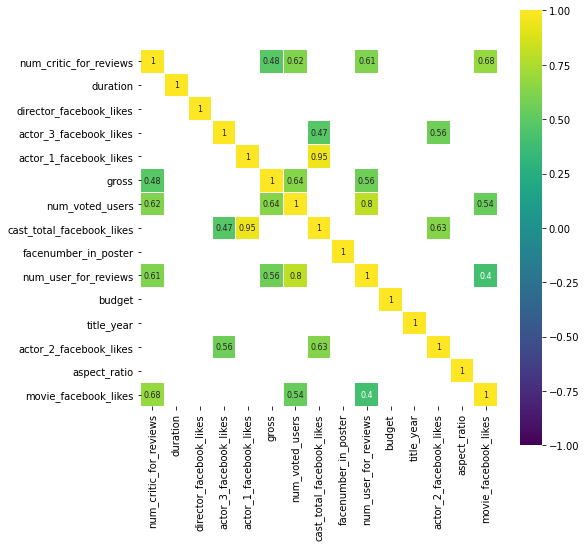

In [10]:
df_num_corr = df_num.drop('imdb_score', axis=1).corr()
plt.figure(figsize=(8, 8))
sns.heatmap(df_num_corr[(df_num_corr >= 0.4) | (df_num_corr <= -0.4)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

A lot of features looks correlated amongst themselves.

`num_critic_for_reviews`/`num_voted_users` or `num_user_for_reviews`/`num_voted_users`. These are obvious as we will have more reviews, when more users will vote for the movie. Similarly, `cast_total_facebook_likes`/`actor_1_facebook_likes` etc.

`movie_facebook_likes`/`num_critic_for_reviews`, users who reviewed has higher chances of liking the movie. Similarly `gross`/`num_voted_users` and `gross`/`num_users_for_reviews`.

So, we can apply PCA to combine numerical features and reduce model complexity.

## Categorical feature plots w.r.t. `imdb_score`

In [11]:
# Couting unqiue values for each categorical variable
df.select_dtypes(exclude = ['float64', 'int64']).T.apply(lambda x: x.nunique(), axis=1)

color                 2
director_name      2398
actor_2_name       3032
genres              914
actor_1_name       2097
movie_title        4917
actor_3_name       3521
plot_keywords      4760
movie_imdb_link    4919
language             47
country              65
content_rating       18
dtype: int64

Most features have almost the similar no. of categories as the no. of data points. This is due to how they are 
written. For eg. - `plot_keywords` has avatar|future|marine|native... etc.

We will not be able to simply one-hot encode most features here, as that will just blow up the feature space. Also, the resulting features will be sparse for something like `actor_1_name`, `actor_2_name` etc.

Majorly, I guess, `country`, `language`, `genres` or `content_rating` can be useful. Since these still have fewer categories, as compared to other categorical features. `genres` may need some special treatment.

We can one-hot encode `color` and mean encoding with target variable the remaining features, in data preparation before model training.

### Plotting a few features vs `imdb_score`, to see their general distribution.

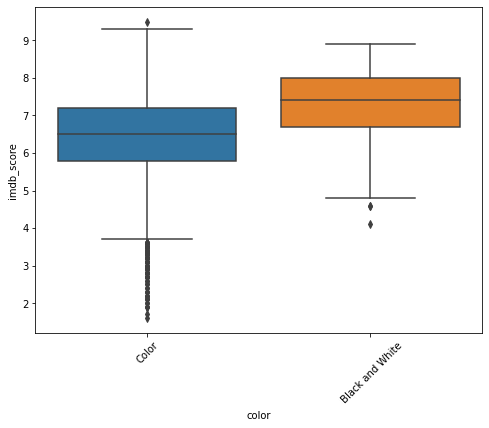

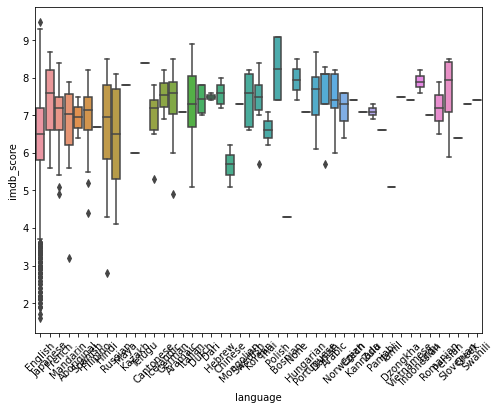

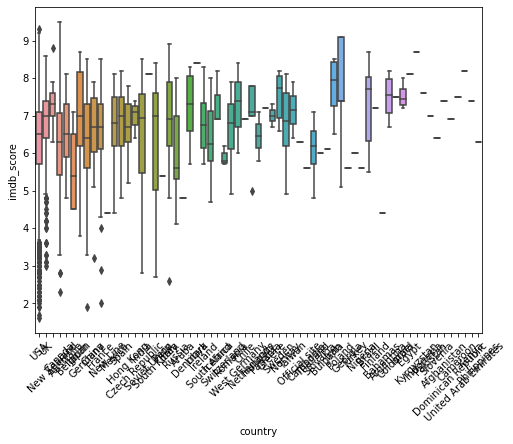

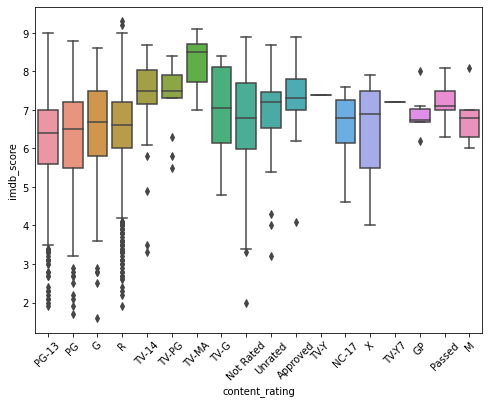

In [12]:
# Plotting boxplots for a few of these categorical features
# These have fewer unique categories compared to others
X_catg = df.select_dtypes(exclude = ['float64', 'int64'])
y = df.select_dtypes(exclude = ['object'])['imdb_score']
df_catg = pd.concat([X_catg, y], axis=1, sort=False, copy=False)

for col in ['color', 'language', 'country', 'content_rating']:
    plt.figure(figsize = (8, 6))
    sns.boxplot(data=df_catg, x=col, y='imdb_score')
    plt.xticks(rotation=45)
    plt.show()

`imdb_score` looks well distributed w.r.t `color`, `language`, `country`, `content_rating` . We can use them in model training.

### Functions to encode categorical features

In [13]:
def custom_lookup_mapper(x, lookup_table):
    score = 0
    
    try:
        genres = x.split('|')
    except:
        return 0
    
    for genre in genres:
        try:
            score += lookup_table[genre]
        except:
            score += 0
    
    avg_value = score / len(genres)
    return avg_value


def encode_special_catgs(train_df, test_df, feat):
    temp_dict = dict()
    for row in train_df.itertuples():
        try:
            genres = [x for x in getattr(row, feat).split('|') if not isinstance(x, float)]
            for genre in genres:
                try:
                    temp_dict[genre]['count'] += 1
                    temp_dict[genre]['sum'] += getattr(row, 'imdb_score')
                except:
                    temp_dict[genre] = {'count': 1, 'sum': getattr(row, 'imdb_score')}
        except:
            # when encountered with a NaN value
            continue
    
    mean_value_dict = dict()
    for k, v in temp_dict.items():
        mean_value_dict[k] = v['sum'] / v['count']

    train_df[feat + '_encoding'] = train_df[feat].apply(lambda x: custom_lookup_mapper(x, mean_value_dict))
    test_df[feat + '_encoding'] = test_df[feat].apply(lambda x: custom_lookup_mapper(x, mean_value_dict))
    
    return train_df, test_df


def treat_categorical_features(train_df, test_df, features):
    # One-hot encoding for color feature
    if 'color' in features:
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        train_df_color_one_hot = enc.fit_transform(train_df['color'].fillna('Color').to_numpy().reshape(-1,1))
        train_df_color_one_hot = pd.DataFrame(train_df_color_one_hot, columns=['color_1_encoding', 'color_2_encoding']).reset_index(drop=True)
        train_df = pd.concat([train_df, train_df_color_one_hot], axis=1, sort=False, copy=False)
        
        test_df_color_one_hot = enc.transform(test_df['color'].fillna('Color').to_numpy().reshape(-1,1))
        test_df_color_one_hot = pd.DataFrame(test_df_color_one_hot, columns=['color_1_encoding', 'color_2_encoding']).reset_index(drop=True)
        test_df = pd.concat([test_df, test_df_color_one_hot], axis=1, sort=False, copy=False)
    
    # Mean target encoding for selected features
    mean_target_features = ['country', 'language', 'content_rating', 'director_name']
    apply_mean_encoding_on = [item for item in mean_target_features if item in features]
    
    for feat in apply_mean_encoding_on:
        group_mean = train_df.groupby(by=feat)['imdb_score'].mean()
        train_df[feat + '_encoding'] = train_df[feat].map(group_mean)
        test_df[feat + '_encoding'] = test_df[feat].map(group_mean)
    
    # Encoding genres feature a bit differently
    if 'genres' in features:
        train_df, test_df = encode_special_catgs(train_df, test_df, 'genres')
    
    if 'plot_keywords' in features:
        train_df, test_df = encode_special_catgs(train_df, test_df, 'plot_keywords')
    
    return train_df, test_df

## Checking if some numerical features can be imputed w.r.t to year

In [14]:
# Making the interval of imdb_score and title_year for better analysis
df['imdb_score_bin'] = pd.cut(df.imdb_score, bins=list(np.arange(1,11)))
df['year_range'] = pd.cut(df.title_year, bins=list(5*(np.arange(380,405))))
df['pc_imdb'] = pd.cut(df.imdb_score, bins=list([0,4,6,7,8,10]))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['pc_imdb']= le.fit_transform(df['pc_imdb'])

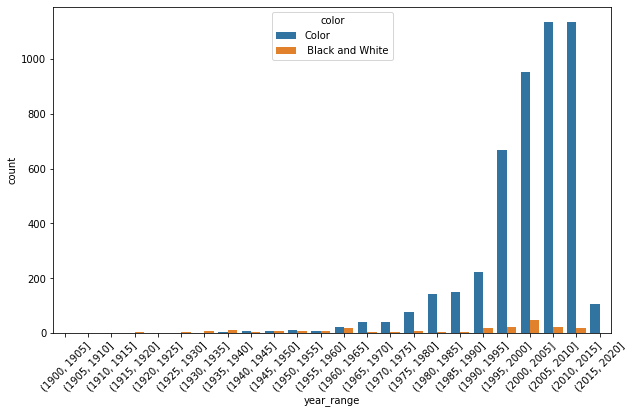

In [15]:
# Plotting to check the distribution of color w.r.t to year range of movie
fig, ax = plt.subplots(figsize=(10,6))
plt.xticks(rotation=45)
sns.countplot(x="year_range", hue="color", data=df)

This graph follow the expected distribution, though some `Black and White` movies are developed in 2000s is surprising.

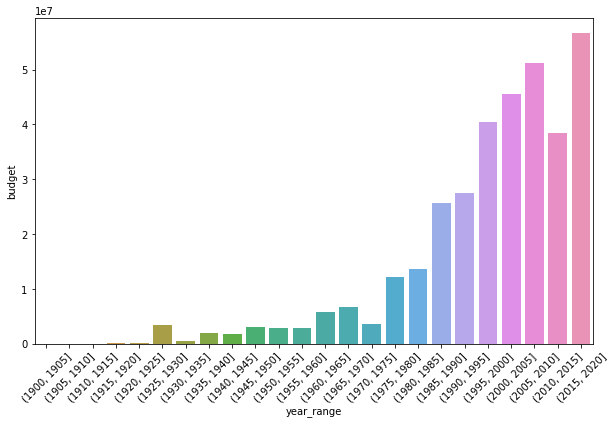

In [16]:
# Plotting to check the distribution of budget w.r.t to year range of movie
fig, ax = plt.subplots(figsize=(10,6))
plt.xticks(rotation=45)
sns.barplot(df['year_range'], df['budget'], ci=None)

`budget` seems to be a function of year, and thus its missing value can be imputed with the mean budget of the year.

In [17]:
def impute_budget(train_df, test_df):
    train_df_null = train_df[train_df['year_range'].isnull()]
    train_df_no_null = train_df[train_df['year_range'].notnull()]
    
    mean_chart = pd.DataFrame(train_df_no_null.groupby(by=['year_range'])['budget'].mean()).reset_index()
    
    train_df_no_null = pd.merge(train_df_no_null, mean_chart, how='left', on='year_range')
    train_df_no_null['budget_x'].fillna(train_df_no_null['budget_y'], inplace=True)
    train_df_no_null.drop('budget_y', axis=1, inplace=True)
    train_df_no_null = train_df_no_null.rename(columns={'budget_x': 'budget'})
    train_df = train_df_no_null.append(train_df_null).reset_index(drop=True)
    
    test_df_null = test_df[test_df['year_range'].isnull()]
    test_df_no_null = test_df[test_df['year_range'].notnull()]
    test_df_no_null = pd.merge(test_df_no_null, mean_chart, how='left', on='year_range')
    test_df_no_null['budget_x'].fillna(test_df_no_null['budget_y'], inplace=True)
    test_df_no_null.drop('budget_y', axis=1, inplace=True)
    test_df_no_null = test_df_no_null.rename(columns={'budget_x': 'budget'})
    test_df = test_df_no_null.append(test_df_null).reset_index(drop=True)
    
    return train_df, test_df

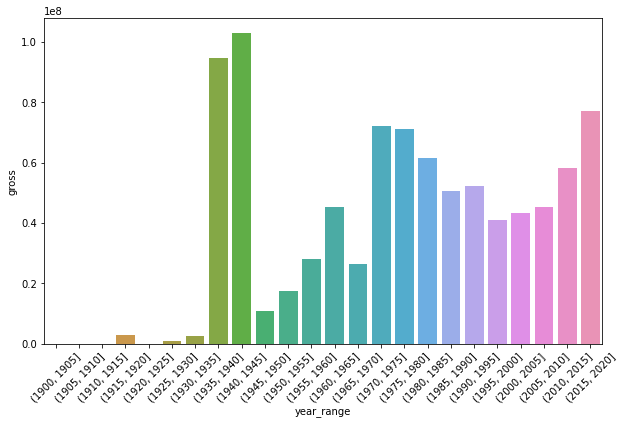

In [18]:
# Plotting to check the distribution of gross w.r.t to year range of movie
fig, ax = plt.subplots(figsize=(10,6))
plt.xticks(rotation=45)
sns.barplot(df['year_range'], df['gross'],ci=None)

`gross` seems to be a function of year, and thus its missing value can be imputed with the mean budget of the year.

In [19]:
def impute_gross(train_df, test_df):
    train_df_null = train_df[train_df['year_range'].isnull()]
    train_df_no_null = train_df[train_df['year_range'].notnull()]
    
    mean_chart = pd.DataFrame(train_df_no_null.groupby(by=['year_range'])['gross'].mean()).reset_index()
    
    train_df_no_null = pd.merge(train_df_no_null, mean_chart, how='left', on='year_range')
    train_df_no_null['gross_x'].fillna(train_df_no_null['gross_y'], inplace=True)
    train_df_no_null.drop('gross_y', axis=1, inplace=True)
    train_df_no_null = train_df_no_null.rename(columns={'gross_x': 'gross'})
    train_df = train_df_no_null.append(train_df_null).reset_index(drop=True)
    
    test_df_null = test_df[test_df['year_range'].isnull()]
    test_df_no_null = test_df[test_df['year_range'].notnull()]
    test_df_no_null = pd.merge(test_df_no_null, mean_chart, how='left', on='year_range')
    test_df_no_null['gross_x'].fillna(test_df_no_null['gross_y'], inplace=True)
    test_df_no_null.drop('gross_y', axis=1, inplace=True)
    test_df_no_null = test_df_no_null.rename(columns={'gross_x': 'gross'})
    test_df = test_df_no_null.append(test_df_null).reset_index(drop=True)
    
    return train_df, test_df

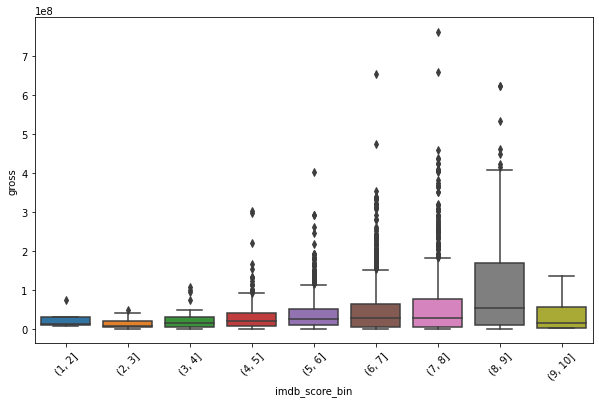

In [20]:
# Plotting to check the distribution of budget w.r.t to imdb_score bin
fig, ax = plt.subplots(figsize=(10,6))
plt.xticks(rotation=45)
sns.boxplot(data=df, x='imdb_score_bin', y='gross')

The combined `gross` income of a movie increases with its `imdb_score` which is pretty obvious, as more people go and watch good movies. At the same time, very rare movies have ratings more than 9, and thus there combined `gross` will be less, due to low absolute no. of movies in this bin.

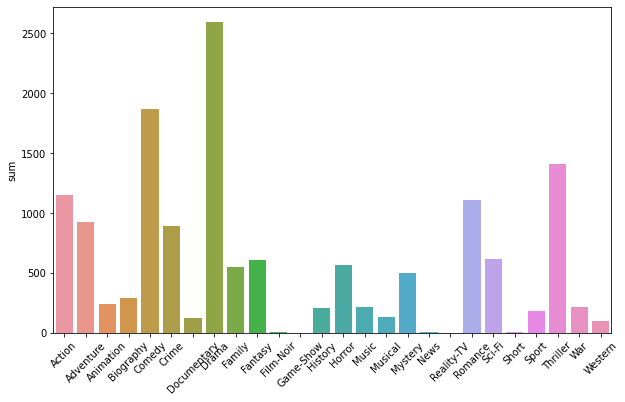

In [21]:
df_genre = df['genres'].str.split('|',expand=True).stack().str.get_dummies().sum(level=0)

fig, ax = plt.subplots(figsize=(10,6))
plt.xticks(rotation=45)
k = pd.DataFrame(df_genre.sum(), columns=['sum'])
sns.barplot(y='sum',x=k.index,data=k,orient='v')

A few genres are really common vs others.

# Model Training

Since the target variable `imdb_score` is a continous variable, we should use a regression model to predict this. We can try multiple types of regression models like Linear or Forest based techniques.

Since, we are doing a multiple regression, we will use adjusted R-squared as our metric to optimise for. The adjusted R-squared is a modified version of R-squared that has been adjusted for the number of predictors in the model. The adjusted R-squared increases only if the new term improves the model more than would be expected by chance. It decreases when a predictor improves the model by less than expected by chance.

We will perform a 5-fold cross validation and check for both model accuracy as well as stability.

In [22]:
X = copy.deepcopy(df.drop('imdb_score', axis=1))
y = copy.deepcopy(df['imdb_score'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_df = pd.concat([X_train, y_train.rename('imdb_score')], axis=1, sort=False, copy=False).reset_index(drop=True)
test_df = pd.concat([X_test, y_test.rename('imdb_score')], axis=1, sort=False, copy=False).reset_index(drop=True)

train_df, test_df = treat_categorical_features(train_df, test_df, ['color', 'country', 'language', 'content_rating', 'genres', 'plot_keywords'])
train_df, test_df = impute_budget(train_df, test_df)
train_df, test_df = impute_gross(train_df, test_df)

### PCA

In [23]:
def perform_pca(train_df, test_df, features, n_components=16, plot_variance=False):
    scaler = StandardScaler()
    train_df_std = scaler.fit_transform(train_df[features].fillna(0))
    test_df_std = scaler.transform(test_df[features].fillna(0))
    
    pca = PCA(n_components=n_components)
    train_df_pca = pca.fit_transform(train_df_std)
    test_df_pca = pca.transform(test_df_std)
    
    if plot_variance:
        cum_sum = pca.explained_variance_ratio_.cumsum()*100
        fig, ax = plt.subplots(figsize=(8,5))
        plt.bar(range(n_components), cum_sum, color = 'b', alpha=0.5)
    
    return train_df_pca, test_df_pca

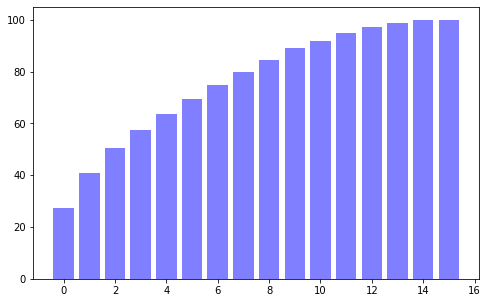

In [24]:
# Checking how many principal component will be needed to get to atleast 90% explained variance
train_df_pca, test_df_pca = perform_pca(train_df, test_df, ['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'budget', 'title_year',
       'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes', 'pc_imdb'], plot_variance=True)

Looks like ~11 components are required to explain atleast 90% variance

### Model data prep, run and predict

In [25]:
def compute_error_metric(y_test, y_pred, n, p):
    r2 = r2_score(y_test, y_pred)
    return 1 - ((1 - r2)*(n - 1)/(n - p - 1))
    
def build_and_run_model(model, df, validate=True, to_encode_features=[], with_pca=False):
    numerical_features = ['num_critic_for_reviews', 'duration', 'director_facebook_likes',
                       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
                       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
                       'num_user_for_reviews', 'budget', 'title_year',
                       'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes']
    
    categorical_features = ['color', 'country', 'language', 'content_rating', 'genres', 'plot_keywords']
    
    to_drop_features = ['imdb_score_bin', 'year_range', 'pc_imdb', 'movie_imdb_link', 'movie_title',
                        'actor_1_name', 'actor_2_name', 'actor_3_name', 'director_name']
    
    X = df.drop('imdb_score', axis=1)
    y = df['imdb_score']
    
    error_metric = []
    
    if not validate:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        
        X_train = copy.deepcopy(X_train)
        X_test = copy.deepcopy(X_test)
        y_train = copy.deepcopy(y_train)
        y_test = copy.deepcopy(y_test)
        
        train_df = pd.concat([X_train, y_train.rename('imdb_score')], axis=1, sort=False, copy=False).reset_index(drop=True)
        test_df = pd.concat([X_test, y_test.rename('imdb_score')], axis=1, sort=False, copy=False).reset_index(drop=True)
        
        # Treating categorical features with one-hot and mean target encoding
        if len(to_encode_features):
            train_df, test_df = treat_categorical_features(train_df, test_df, to_encode_features)
        
        train_df.drop(categorical_features, axis=1, inplace=True)
        test_df.drop(categorical_features, axis=1, inplace=True)
        
        # Imputing missing values
        train_df, test_df = impute_budget(train_df, test_df)
        train_df, test_df = impute_gross(train_df, test_df)
        
        train_df.drop(to_drop_features, axis=1, inplace=True)
        test_df.drop(to_drop_features, axis=1, inplace=True)
        
        if with_pca:
            train_df_pca, test_df_pca = perform_pca(train_df, test_df, numerical_features, n_components=11)
            train_df_pca = pd.DataFrame(train_df_pca)
            test_df_pca = pd.DataFrame(test_df_pca)
            
            train_df.drop(numerical_features, axis=1, inplace=True)
            test_df.drop(numerical_features, axis=1, inplace=True)
            
            train_df = pd.concat([train_df, train_df_pca], axis=1, sort=False, copy=False)
            test_df = pd.concat([test_df, test_df_pca], axis=1, sort=False, copy=False)
        
        X_train = train_df.fillna(0).drop('imdb_score', axis=1)
        y_train = train_df['imdb_score']
        
        X_test = test_df.fillna(0).drop('imdb_score', axis=1)
        y_test = test_df['imdb_score']
        
        model.fit(X_train, y_train)
        
        return model.best_score_, model.best_params_

    for train_index, test_index in KFold(n_splits=5).split(X, y):
        X_train = copy.deepcopy(X.iloc[train_index.tolist(),:]).reset_index(drop=True)
        X_test = copy.deepcopy(X.iloc[test_index.tolist(),:]).reset_index(drop=True)
        
        y_train = copy.deepcopy(y.iloc[train_index.tolist()]).reset_index(drop=True)
        y_test = copy.deepcopy(y.iloc[test_index.tolist()]).reset_index(drop=True)
        
        train_df = pd.concat([X_train, y_train.rename('imdb_score')], axis=1, sort=False, copy=False).reset_index(drop=True)
        test_df = pd.concat([X_test, y_test.rename('imdb_score')], axis=1, sort=False, copy=False).reset_index(drop=True)
        
        # Treating categorical features with one-hot and mean target encoding
        if len(to_encode_features):
            train_df, test_df = treat_categorical_features(train_df, test_df, to_encode_features)
        
        train_df.drop(categorical_features, axis=1, inplace=True)
        test_df.drop(categorical_features, axis=1, inplace=True)
        
        # Imputing missing values
        train_df, test_df = impute_budget(train_df, test_df)
        train_df, test_df = impute_gross(train_df, test_df)
        
        train_df.drop(to_drop_features, axis=1, inplace=True)
        test_df.drop(to_drop_features, axis=1, inplace=True)
        
        if with_pca:
            train_df_pca, test_df_pca = perform_pca(train_df, test_df, numerical_features, n_components=11)
            train_df_pca = pd.DataFrame(train_df_pca)
            test_df_pca = pd.DataFrame(test_df_pca)
            
            train_df.drop(numerical_features, axis=1, inplace=True)
            test_df.drop(numerical_features, axis=1, inplace=True)
            
            train_df = pd.concat([train_df, train_df_pca], axis=1, sort=False, copy=False)
            test_df = pd.concat([test_df, test_df_pca], axis=1, sort=False, copy=False)
        
        X_train = train_df.fillna(0).drop('imdb_score', axis=1)
        y_train = train_df['imdb_score']
        
        X_test = test_df.fillna(0).drop('imdb_score', axis=1)
        y_test = test_df['imdb_score']
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        error_metric.append(compute_error_metric(y_test, y_pred, X_train.shape[0], X_train.shape[1]))
    
    return np.mean(error_metric), np.std(error_metric)

### Linear Regression

In [26]:
# Model 1
lin_reg = LinearRegression(normalize=True)

mean_error_metric, std_error_metric = build_and_run_model(lin_reg, df)
print('With only numerical features')
print('Mean of adjusted R-squared: {}'.format(mean_error_metric))
print('Standard deviation of adjusted R-squared: {}'.format(std_error_metric))
    
for feat in ['color', 'country', 'language', 'content_rating', 'genres', 'plot_keywords']:
    mean_error_metric, std_error_metric = build_and_run_model(lin_reg, df, to_encode_features=[feat])
    
    print('\nWith categorical feature {} along with numerical features'.format(feat))
    print('Mean of adjusted R-squared: {}'.format(mean_error_metric))
    print('Standard deviation of adjusted R-squared: {}'.format(std_error_metric))

With only numerical features
Mean of adjusted R-squared: 0.22805715978255997
Standard deviation of adjusted R-squared: 0.09358726307883873

With categorical feature color along with numerical features
Mean of adjusted R-squared: 0.24799462185610438
Standard deviation of adjusted R-squared: 0.08224444555322162

With categorical feature country along with numerical features
Mean of adjusted R-squared: 0.1766309909173787
Standard deviation of adjusted R-squared: 0.12397809629953042

With categorical feature language along with numerical features
Mean of adjusted R-squared: 0.20761118822066962
Standard deviation of adjusted R-squared: 0.12403034066931132

With categorical feature content_rating along with numerical features
Mean of adjusted R-squared: 0.2281096837578481
Standard deviation of adjusted R-squared: 0.09326241023721028

With categorical feature genres along with numerical features
Mean of adjusted R-squared: 0.309776313330961
Standard deviation of adjusted R-squared: 0.10495935

In [28]:
mean_error_metric, std_error_metric = build_and_run_model(lin_reg, df,
                                                          to_encode_features=['color', 'content_rating', 'genres'])
print('With numerical features and top categorical features')
print('Mean of adjusted R-squared: {}'.format(mean_error_metric))
print('Standard deviation of adjusted R-squared: {}'.format(std_error_metric))

mean_error_metric, std_error_metric = build_and_run_model(lin_reg, df,
                                                          to_encode_features=['color', 'content_rating', 'genres'],
                                                          with_pca=True)
print('\nWith numerical features and top categorical features along with PCA')
print('Mean of adjusted R-squared: {}'.format(mean_error_metric))
print('Standard deviation of adjusted R-squared: {}'.format(std_error_metric))

With numerical features and top categorical features
Mean of adjusted R-squared: 0.32449019939470186
Standard deviation of adjusted R-squared: 0.09312037341638342

With numerical features and top categorical features along with PCA
Mean of adjusted R-squared: 0.26369677962238025
Standard deviation of adjusted R-squared: 0.10741493730549853


### RandomForest Regression

In [29]:
# Model 2
rf_reg = RandomForestRegressor()
parameters = {'max_depth': [5, 7, 9],
              'min_samples_split': [3, 4, 5],
              'max_features': ['log2', 'sqrt'],
              'n_estimators': [x for x in range(50, 300, 50)]}

rf_grid = GridSearchCV(rf_reg,
                        parameters,
                        cv=2,
                        n_jobs=5,
                        verbose=True)

rf_best_score, rf_best_params = build_and_run_model(rf_grid, df, validate=False)
print('Best model score: {}'.format(rf_best_score))
print('Best model params: {}'.format(rf_best_params))

Fitting 2 folds for each of 90 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   13.4s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:  1.0min finished


Best model score: 0.4231106598010826
Best model params: {'max_depth': 9, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 150}


##### Re-building with best params and to check for top categorical features

In [30]:
rf_reg = RandomForestRegressor(n_estimators=rf_best_params['n_estimators'],
                               max_depth=rf_best_params['max_depth'],
                               max_features=rf_best_params['max_features'],
                               min_samples_split=rf_best_params['min_samples_split'])

mean_error_metric, std_error_metric = build_and_run_model(rf_reg, df)
print('With only numerical features')
print('Mean of adjusted R-squared: {}'.format(mean_error_metric))
print('Standard deviation of adjusted R-squared: {}'.format(std_error_metric))
    
for feat in ['color', 'country', 'language', 'content_rating', 'genres', 'plot_keywords']:
    mean_error_metric, std_error_metric = build_and_run_model(rf_reg, df, to_encode_features=[feat])
    
    print('\nWith categorical feature {} along with numerical features'.format(feat))
    print('Mean of adjusted R-squared: {}'.format(mean_error_metric))
    print('Standard deviation of adjusted R-squared: {}'.format(std_error_metric))

With only numerical features
Mean of adjusted R-squared: 0.4135577853322567
Standard deviation of adjusted R-squared: 0.06620063148890167

With categorical feature color along with numerical features
Mean of adjusted R-squared: 0.4182285448782522
Standard deviation of adjusted R-squared: 0.06925130292569741

With categorical feature country along with numerical features
Mean of adjusted R-squared: 0.4165692492276672
Standard deviation of adjusted R-squared: 0.07640135631814314

With categorical feature language along with numerical features
Mean of adjusted R-squared: 0.41915628934907545
Standard deviation of adjusted R-squared: 0.07050896207192076

With categorical feature content_rating along with numerical features
Mean of adjusted R-squared: 0.42213324215041237
Standard deviation of adjusted R-squared: 0.0692132870016025

With categorical feature genres along with numerical features
Mean of adjusted R-squared: 0.49206973576168467
Standard deviation of adjusted R-squared: 0.05964124

##### Re-building with best param and top categorical features
Top categorical features are chosen as such which increases the error metric over baseline numerical feature only model.

In [31]:
rf_reg = RandomForestRegressor(n_estimators=rf_best_params['n_estimators'],
                               max_depth=rf_best_params['max_depth'],
                               max_features=rf_best_params['max_features'],
                               min_samples_split=rf_best_params['min_samples_split'])

mean_error_metric, std_error_metric = build_and_run_model(rf_reg, df,
                                                          to_encode_features=['color', 'country', 'language', 'content_rating', 'genres'])
print('With numerical features and top categorical features')
print('Mean of adjusted R-squared: {}'.format(mean_error_metric))
print('Standard deviation of adjusted R-squared: {}'.format(std_error_metric))

mean_error_metric, std_error_metric = build_and_run_model(rf_reg, df,
                                                          to_encode_features=['color', 'country', 'language', 'content_rating', 'genres'],
                                                          with_pca=True)
print('\nWith numerical features and top categorical features along with PCA')
print('Mean of adjusted R-squared: {}'.format(mean_error_metric))
print('Standard deviation of adjusted R-squared: {}'.format(std_error_metric))

With numerical features and top categorical features
Mean of adjusted R-squared: 0.4856298471939896
Standard deviation of adjusted R-squared: 0.06087658653414686

With numerical features and top categorical features along with PCA
Mean of adjusted R-squared: 0.38385349781929196
Standard deviation of adjusted R-squared: 0.08598007071818907


### XGB Regression

In [32]:
xgb_reg = xgb.XGBRegressor()
parameters = {'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6],
              'min_child_weight': [4, 5],
              'subsample': [0.6, 0.7],
              'colsample_bytree': [0.6, 0.7],
              'n_estimators': [x for x in range(200, 600, 100)]}

xgb_grid = GridSearchCV(xgb_reg,
                        parameters,
                        cv=2,
                        n_jobs=5,
                        verbose=True)

xgb_best_score, xgb_best_params = build_and_run_model(xgb_grid, df, validate=False)
print('Best model score: {}'.format(xgb_best_score))
print('Best model params: {}'.format(xgb_best_params))

Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   18.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 384 out of 384 | elapsed:  3.3min finished


Best model score: 0.4855376127238565
Best model params: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.7}


##### Re-building with best param and to check for top categorical features

In [33]:
xgb_reg = xgb.XGBRegressor(learning_rate=xgb_best_params['learning_rate'],
                           colsample_bytree=xgb_best_params['colsample_bytree'],
                           max_depth=xgb_best_params['max_depth'],
                           min_child_weight=xgb_best_params['min_child_weight'],
                           n_estimators=xgb_best_params['n_estimators'],
                           subsample=xgb_best_params['subsample'])

mean_error_metric, std_error_metric = build_and_run_model(xgb_reg, df)
print('\nWith only numerical features')
print('Mean of adjusted R-squared: {}'.format(mean_error_metric))
print('Standard deviation of adjusted R-squared: {}'.format(std_error_metric))
    
for feat in ['color', 'country', 'language', 'content_rating', 'genres', 'plot_keywords']:
    mean_error_metric, std_error_metric = build_and_run_model(xgb_reg, df, to_encode_features=[feat])
    
    print('\nWith categorical feature {} along with numerical features'.format(feat))
    print('Mean of adjusted R-squared: {}'.format(mean_error_metric))
    print('Standard deviation of adjusted R-squared: {}'.format(std_error_metric))


With only numerical features
Mean of adjusted R-squared: 0.4908771755003876
Standard deviation of adjusted R-squared: 0.09499513683203746

With categorical feature color along with numerical features
Mean of adjusted R-squared: 0.49476601566132317
Standard deviation of adjusted R-squared: 0.09116935225630035

With categorical feature country along with numerical features
Mean of adjusted R-squared: 0.48859321260834
Standard deviation of adjusted R-squared: 0.09843831629816792

With categorical feature language along with numerical features
Mean of adjusted R-squared: 0.4988870995794531
Standard deviation of adjusted R-squared: 0.096811664527988

With categorical feature content_rating along with numerical features
Mean of adjusted R-squared: 0.49664397896720824
Standard deviation of adjusted R-squared: 0.0922290687429529

With categorical feature genres along with numerical features
Mean of adjusted R-squared: 0.5505969765026418
Standard deviation of adjusted R-squared: 0.078209389937

##### Re-building with best param and top categorical features
Top categorical features are chosen as such which increases the error metric over baseline numerical feature only model.

In [34]:
xgb_reg = xgb.XGBRegressor(learning_rate=xgb_best_params['learning_rate'],
                           colsample_bytree=xgb_best_params['colsample_bytree'],
                           max_depth=xgb_best_params['max_depth'],
                           min_child_weight=xgb_best_params['min_child_weight'],
                           n_estimators=xgb_best_params['n_estimators'],
                           subsample=xgb_best_params['subsample'])

mean_error_metric, std_error_metric = build_and_run_model(xgb_reg, df,
                                                          to_encode_features=['color', 'country', 'language', 'content_rating', 'genres'])
print('With numerical features and top categorical features')
print('Mean of adjusted R-squared: {}'.format(mean_error_metric))
print('Standard deviation of adjusted R-squared: {}'.format(std_error_metric))

mean_error_metric, std_error_metric = build_and_run_model(xgb_reg, df,
                                                          to_encode_features=['color', 'country', 'language', 'content_rating', 'genres'],
                                                          with_pca=True)
print('\nWith numerical features and top categorical features along with PCA')
print('Mean of adjusted R-squared: {}'.format(mean_error_metric))
print('Standard deviation of adjusted R-squared: {}'.format(std_error_metric))

With numerical features and top categorical features
Mean of adjusted R-squared: 0.5683203832985885
Standard deviation of adjusted R-squared: 0.07054689043323503

With numerical features and top categorical features along with PCA
Mean of adjusted R-squared: 0.4339986493293743
Standard deviation of adjusted R-squared: 0.08759548300522625


# Result and Conclusion

We tried 3 diffrent types of regression to predict the contnious target variable `imdb_score`

We chose adjusted R-squared as our metric to evaluate the model. The adjusted R-squared is a modified version of R-squared that has been adjusted for the number of predictors in the model. The adjusted R-squared increases only if the new term improves the model more than would be expected by chance. It decreases when a predictor improves the model by less than expected by chance.

The numerical features are not highly correlated to `imdb_score`, and thus model accuracy decreases when applyling PCA. This might be happening due to information loss in an already low correlated feature space.

Moreover, because of this low linear relatationship between independent variables and target variable, linear models perform poorly. Linear regression is a linear model, which means it works really nicely when the data has a linear shape. But, when the data has a non-linear shape, then a linear model cannot capture this well. So, in this case, we chose to use tree based models, which did a better job at capturing the non-linearity in the data. They divide the space into smaller sub-spaces and an ensemble of independent estimators, which decreases the model complexity while keeping the bias low at the same time.

###### Top Categorical Features
`color`, `country`, `language`, `content_rating` and `genres`

###### Best Linear Regression Model
With numerical features and top categorical features
<br>
Mean of adjusted R-squared: `0.3245`
<br>
Standard deviation of adjusted R-squared: `0.0931`
<br>
###### Best RandomForest Regression Model
With categorical feature `genres` along with numerical features
<br>
Mean of adjusted R-squared: `0.4921`
<br>
Standard deviation of adjusted R-squared: `0.0596`
<br>
###### Best XGB Regression Model
With numerical features and top categorical features
<br>
Mean of adjusted R-squared: `0.5683`
<br>
Standard deviation of adjusted R-squared: `0.0705`
<br>
###### Overall Best Model
XGB Regression with numerical and top categorical features performed the best, with mean adjusted R-squared `0.5683`